In [19]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os

import ast

from scipy.stats import wilcoxon

import time
from collections import Counter
import warnings; warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/giles/Projects/pyShapelets/pyshapelets')

from data.load_all_datasets import load_data_train_test
from algorithms import ShapeletTreeClassifier, ShapeletTransformer
import util
from extractors.extractor import SAXExtractor

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [24]:
# Let's create an artificial dataset, based on a real dataset, where a single pass will perform badly on.
# Create an imbalanced multi-class dataset, and make all time series within the majority class very similar to eachother


train_data = pd.read_csv('/home/giles/Projects/pyShapelets/pyshapelets/data/partitioned/MedicalImages/MedicalImages_train.csv').reset_index(drop=True)
test_data = pd.read_csv('/home/giles/Projects/pyShapelets/pyshapelets/data/partitioned/MedicalImages/MedicalImages_test.csv').reset_index(drop=True)
data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

print(Counter(data['target']))
majority_example = data[data['target'] == 1].drop('target', axis=1).sample(1, random_state=2018).iloc[0, :].values

X_train = []
y_train = []
for _ in range(25):
    X_train.append((majority_example + np.random.random(size=len(majority_example))/5))
    y_train.append(0)
    
X_train = np.array(X_train)
y_train = np.array(y_train)

test_majority_samples = data[data['target'] == 1].sample(11, random_state=2018).iloc[1:, :]
X_test = test_majority_samples.drop('target', axis=1)
y_test = [0]*len(X_test)
print(Counter(data['target']))

other_classes = range(2, 5)
for c in other_classes:
    class_idx = data[data['target'] == c].index
    train_idx = data[data['target'] == c].sample(5, random_state=1337).index
    test_idx = list(set(class_idx) - set(train_idx))
    
    X_train = np.vstack((X_train, data.loc[train_idx, :].drop('target', axis=1).values))
    y_train = np.hstack((y_train, [c - 1]*len(train_idx)))
    
    X_test = np.vstack((X_test, data.loc[test_idx, :].drop('target', axis=1).values))
    y_test = np.hstack((y_test, [c - 1]*len(test_idx)))
    
X_train = X_train[:, :50]
X_test = X_test[:, :50]

Counter({10: 594, 1: 112, 9: 106, 3: 75, 2: 65, 7: 49, 4: 48, 5: 45, 8: 24, 6: 23})
Counter({10: 594, 1: 112, 9: 106, 3: 75, 2: 65, 7: 49, 4: 48, 5: 45, 8: 24, 6: 23})


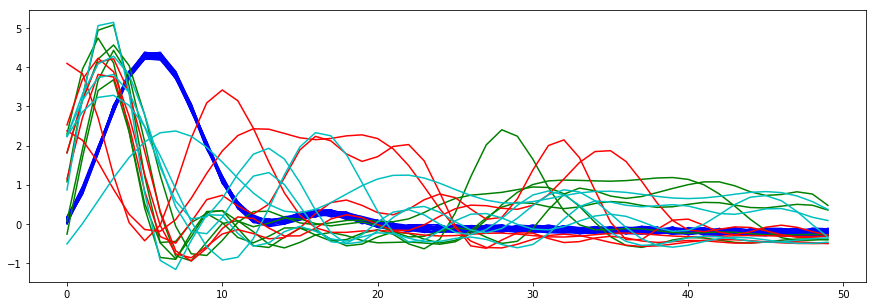

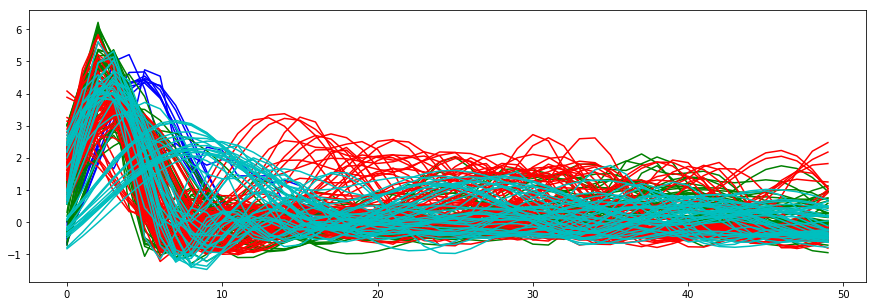

In [25]:
#{'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'}
cmap = {
    0: 'b',
    1: 'g',
    2: 'r',
    3: 'c',
    4: 'm',
    5: 'y',
    6: 'k',
    7: 'w',
}

plt.figure(figsize=(15, 5))
for shap, label in zip(X_train, y_train):
    plt.plot(range(len(shap)), shap, c=cmap[label])
plt.show()

plt.figure(figsize=(15, 5))
for shap, label in zip(X_test, y_test):
    plt.plot(range(len(shap)), shap, c=cmap[label])
plt.show()

In [ ]:
def extract_shapelets_with_tree(X_train, y_train, extractor, min_len, max_len):
    shap_tree_clf = ShapeletTreeClassifier(method=extractor, min_len=min_len,
                                           max_len=max_len)
    shap_tree_clf.fit(X_train, y_train)
    return shap_tree_clf.tree.extract_all_shapelets()

extractor = SAXExtractor(alphabet_size=4, sax_length=16, nr_candidates=100, 
                         iterations=5, mask_size=3)
tree_shapelets = extract_shapelets_with_tree(X_train, y_train, extractor, 3, 80)

shap_transformer = ShapeletTransformer()

length:  26%|██▌       | 20/77 [05:54<16:50, 17.72s/it]

In [ ]:
plt.figure(figsize=(15, 5))
for shap in tree_shapelets:
    plt.plot(range(len(shap)), shap, c='r')
plt.show()

In [ ]:
shap_transformer = ShapeletTransformer(method=extractor, nr_shapelets=X_train.shape[1] // 2, min_len=3, max_len=80)
shap_transformer.fit(X_train, y_train)
transformer_shapelets = shap_transformer.shapelets

In [ ]:
plt.figure(figsize=(15, 5))
for shap in transformer_shapelets:
    plt.plot(range(len(shap)), shap, c='r')
for shap in tree_shapelets:
    plt.plot(range(len(shap)), shap, c='b')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

st = ShapeletTransformer()
st.shapelets = tree_shapelets
features = st.transform(X_test)
rf = GridSearchCV(RandomForestClassifier(random_state=1337), {'n_estimators': [5, 10, 50, 100, 500, 1000]})
rf.fit(st.transform(X_train), y_train)
print(rf.score(features, y_test))

st = ShapeletTransformer()
st.shapelets = transformer_shapelets
features = st.transform(X_test)
rf = GridSearchCV(RandomForestClassifier(random_state=1337), {'n_estimators': [5, 10, 50, 100, 500, 1000]})
rf.fit(st.transform(X_train), y_train)
print(rf.score(features, y_test))

In [ ]:
from sklearn.linear_model import LogisticRegression

st = ShapeletTransformer()
st.shapelets = tree_shapelets
features = st.transform(X_test)
lr = LogisticRegression()
lr.fit(st.transform(X_train), y_train)
print(lr.score(features, y_test))

st = ShapeletTransformer()
st.shapelets = transformer_shapelets
features = st.transform(X_test)
lr = LogisticRegression()
lr.fit(st.transform(X_train), y_train)
print(lr.score(features, y_test))